### Importing Libraries

In [72]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set all seed
def set_seed(seed=42):
    np.random.seed(seed)
seed = 0
set_seed(seed)

### Defining Important Functions

In [73]:
def plot_data(df, x_col, y_col, title, xlabel, ylabel, figsize=(15,5)):
    plt.figure(figsize=figsize)
    plt.plot(df[x_col], df[y_col])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

def calculate_nse(observed, predicted):
    """Calculate Nash-Sutcliffe Efficiency (NSE)"""
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - np.mean(observed)) ** 2)
    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):
    """Calculate Root Mean Square Error (RMSE)"""
    rmse = np.sqrt(np.mean((observed - predicted) ** 2))
    return rmse


def calculate_mae(observed, predicted):
    """Calculate Mean Absolute Error (MAE)"""
    mae = np.mean(np.abs(observed - predicted))
    return mae

def calculate_physical_consistency(observed, predicted):
    """Check if predicted values are realistic (e.g., non-negative)"""
    consistency = np.all(predicted >= 0)
    return consistency

# Calculate performance metrics
def calc_metrics(observed, predicted):
    rmse = calculate_rmse(observed, predicted)
    mae = calculate_mae(observed, predicted)
    nse = calculate_nse(observed, predicted)
    physical_consistency = calculate_physical_consistency(observed, predicted)
    print(f"RMSE = {rmse:.8f}, MAE = {mae:.8f}, NSE = {nse:.8f}, Physical Consistency = {physical_consistency}")
    return rmse, mae, nse, physical_consistency

### Loading Data

In [74]:
data_dir = '/content/'

train_df = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))
train_df['valid_time'] = pd.to_datetime(train_df['valid_time'])
print("Number of rows in training data:", len(train_df))
# format: # year,month,day,hour,yearly_mean,yearly_max,yearly_min,yearly_std,yearly_var,monthly_mean,monthly_max,monthly_min,monthly_std,monthly_var,daily_mean,daily_max,daily_min,daily_std,daily_var

val_df = pd.read_csv(os.path.join(data_dir, 'val_data.csv'))
val_df['valid_time'] = pd.to_datetime(val_df['valid_time'])
print("Number of rows in validation data:", len(val_df))

test_df = pd.read_csv(os.path.join(data_dir, 'test_data.csv'))
test_df['valid_time'] = pd.to_datetime(test_df['valid_time'])
print("Number of rows in test data:", len(test_df))


Number of rows in training data: 87672
Number of rows in validation data: 17520
Number of rows in test data: 17544


In [75]:
features = ['year', 'month', 'day', 'hour', 'yearly_mean', 'yearly_max', 'yearly_min', 'yearly_std', 'yearly_var', 'monthly_mean', 'monthly_max', 'monthly_min', 'monthly_std', 'monthly_var']
target = ['tp', 'daily_mean']

## Random Forest Regressor

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [77]:
# Prepare feature matrices and target vectors for each set
X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=seed)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

(730, 3)
Validation on Hourly Predictions: 
RMSE = 0.00041161, MAE = 0.00024273, NSE = 0.04638027, Physical Consistency = True
Validation on Daily Predictions: 
RMSE = 0.00043142, MAE = 0.00024467, NSE = 0.06608380, Physical Consistency = True


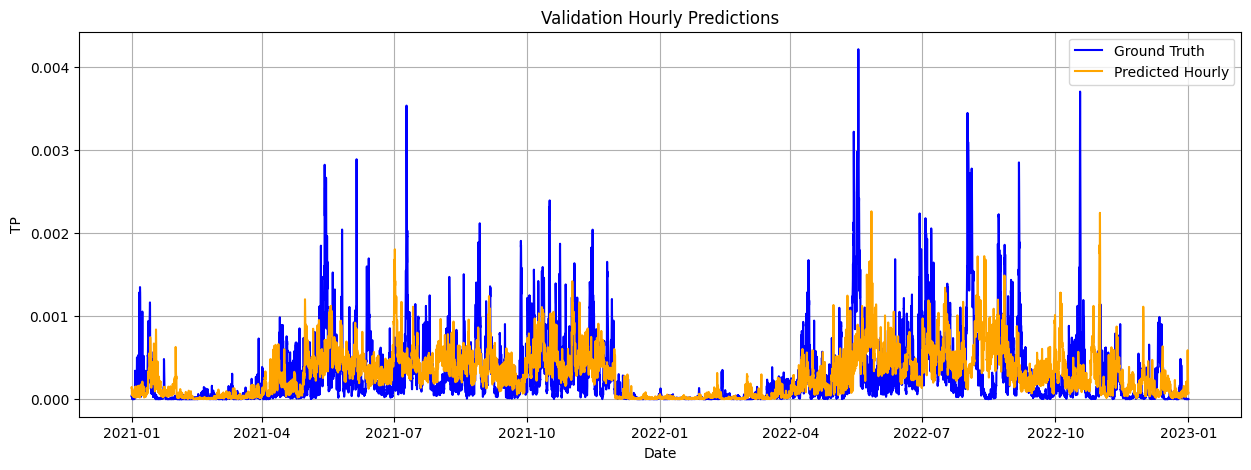

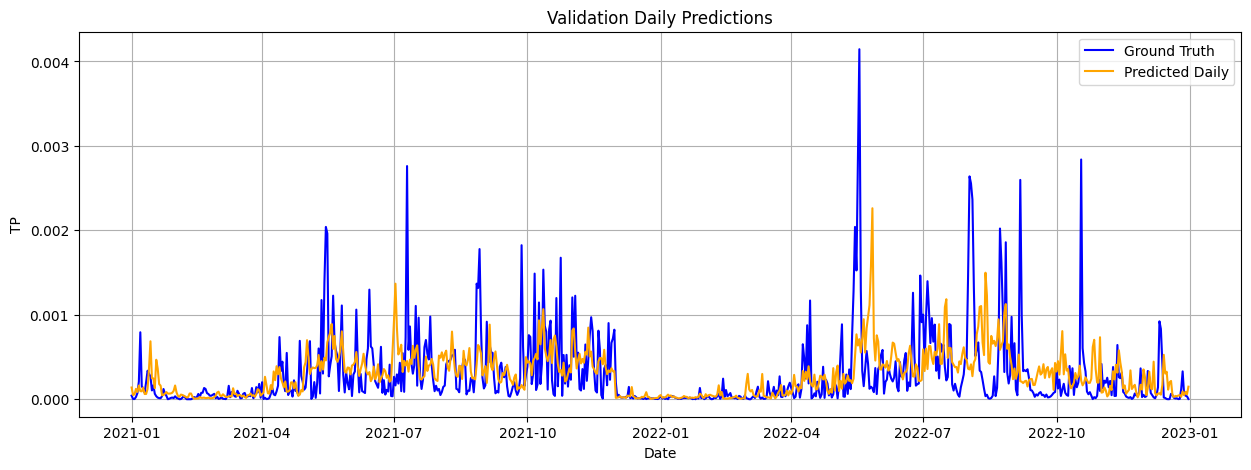

In [78]:
# Predict on validation
y_val_pred = rf_model.predict(X_val)

daily_pred_df_val = pd.merge(val_df[['valid_time']], pd.DataFrame(y_val_pred, columns=target), left_index=True, right_index=True)
daily_pred_df_val = daily_pred_df_val[daily_pred_df_val['valid_time'].dt.hour == 0]
print(daily_pred_df_val.shape)

print(f"Validation on Hourly Predictions: ")
rmse_val, mae_val, nse_val, _ = calc_metrics(val_df['tp'], y_val_pred[:, 0])
print(f"Validation on Daily Predictions: ")
rmse_val, mae_val, nse_val, _ = calc_metrics(val_df[val_df['valid_time'].dt.hour == 0]['tp'], daily_pred_df_val['tp'])

# plot ground truth vs prediction for validation set
plt.figure(figsize=(15,5))
plt.plot(val_df['valid_time'], val_df['tp'], label='Ground Truth', color='blue')
plt.plot(val_df['valid_time'], y_val_pred[:, 0], label='Predicted Hourly', color='orange')
plt.title('Validation Hourly Predictions')
plt.xlabel('Date')
plt.ylabel('TP')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(val_df[val_df['valid_time'].dt.hour == 0]['valid_time'], val_df[val_df['valid_time'].dt.hour == 0]['tp'], label='Ground Truth', color='blue')
plt.plot(daily_pred_df_val['valid_time'], daily_pred_df_val['tp'], label='Predicted Daily', color='orange')
plt.title('Validation Daily Predictions')
plt.xlabel('Date')
plt.ylabel('TP')
plt.legend()
plt.grid()
plt.show()

(731, 3)
Test on Hourly Predictions: 
RMSE = 0.00037807, MAE = 0.00021609, NSE = 0.18877904, Physical Consistency = True
Test on Daily Predictions: 
RMSE = 0.00041587, MAE = 0.00022265, NSE = 0.17124460, Physical Consistency = True


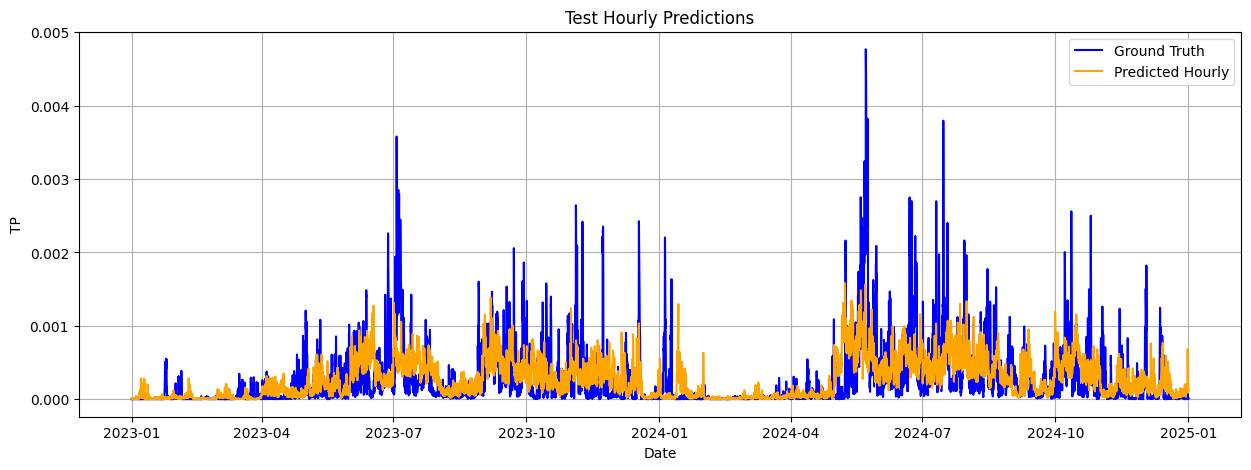

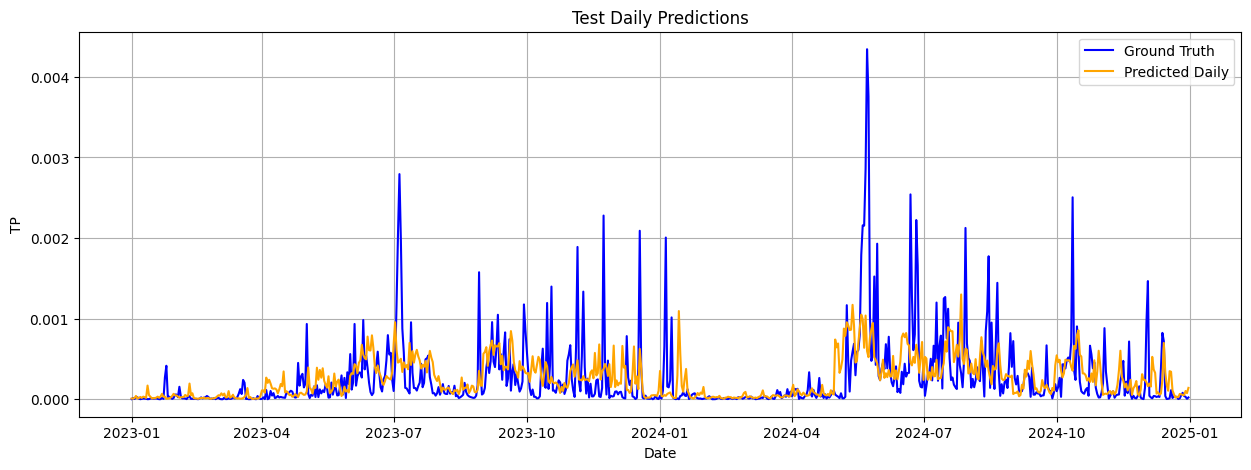

In [79]:
# Predict on test
y_test_pred = rf_model.predict(X_test)

daily_pred_df_test = pd.merge(test_df[['valid_time']], pd.DataFrame(y_test_pred, columns=target), left_index=True, right_index=True)
daily_pred_df_test = daily_pred_df_test[daily_pred_df_test['valid_time'].dt.hour == 0]
print(daily_pred_df_test.shape)
print(f"Test on Hourly Predictions: ")
rmse_test, mae_test, nse_test, _ = calc_metrics(test_df['tp'], y_test_pred[:, 0])
print(f"Test on Daily Predictions: ")
rmse_test, mae_test, nse_test, _ = calc_metrics(test_df[test_df['valid_time'].dt.hour == 0]['tp'], daily_pred_df_test['tp'])

# plot ground truth and predictions
plt.figure(figsize=(15,5))
plt.plot(test_df['valid_time'], test_df['tp'], label='Ground Truth', color='blue')
plt.plot(test_df['valid_time'], y_test_pred[:, 0], label='Predicted Hourly', color='orange')
plt.title('Test Hourly Predictions')
plt.xlabel('Date')
plt.ylabel('TP')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(test_df[test_df['valid_time'].dt.hour == 0]['valid_time'], test_df[test_df['valid_time'].dt.hour == 0]['tp'], label='Ground Truth', color='blue')
plt.plot(daily_pred_df_test['valid_time'], daily_pred_df_test['tp'], label='Predicted Daily', color='orange')
plt.title('Test Daily Predictions')
plt.xlabel('Date')
plt.ylabel('TP')
plt.legend()
plt.grid()
plt.show()

In [80]:
# save model
import joblib
model_path = 'rf_model.pkl'
joblib.dump(rf_model, model_path)
print(f"Model saved to {model_path}")

Model saved to rf_model.pkl
